In [16]:
from dolphin.phase_link import simulate, covariance, _core
import numpy as np
import matplotlib.pyplot as plt
from dolphin import Strides, HalfWindow

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up a simulate stack of deformation with correlated noise

In [75]:
num_time, *shape2d = 20, 128, 128
num_pixels = np.prod(shape2d)

C, _ = simulate.simulate_coh(num_time)
defo_stack = simulate.make_defo_stack((num_time, *shape2d), sigma=20, max_amplitude=8)
defo_phase = np.exp(1j * defo_stack)


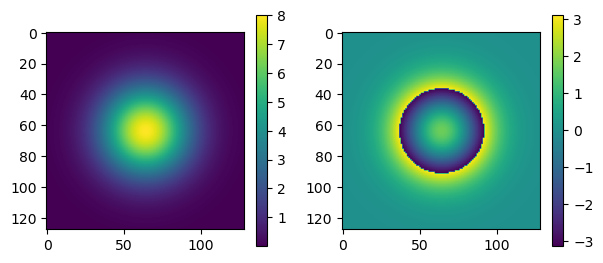

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
axim = axes[0].imshow(defo_stack[-1])
fig.colorbar(axim, ax=axes[0])

axim = axes[1].imshow(np.angle(defo_phase[-1]))
fig.colorbar(axim, ax=axes[1])

In [79]:
samps3d = simulate.create_noisy_deformation(C, defo_stack)

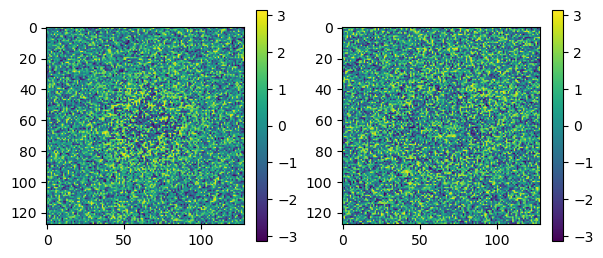

In [97]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))

img1 = np.angle(samps3d[0].conj() * samps3d[10])
img2 = np.angle(samps3d[0].conj() * samps3d[-1])

for ax, img in zip(axes, [img1, img2]):
    axim = ax.imshow(img)
    fig.colorbar(axim, ax=ax)


## Run phase linking on the simulated stack to recover the deformation

In [81]:
strides = Strides(1, 1)
half_window = HalfWindow(5, 5)

### Run the EMI algorithm

CPU times: user 2.96 s, sys: 293 ms, total: 3.25 s
Wall time: 2.29 s


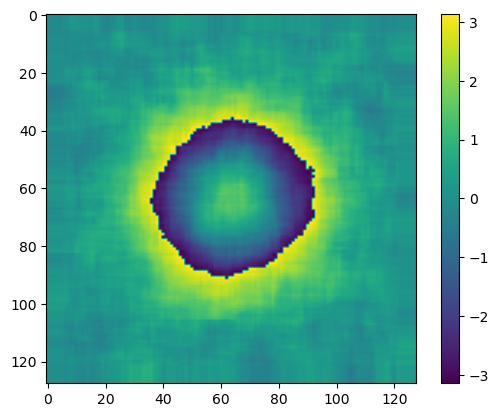

In [82]:
%%time
pl_out_emi = _core.run_phase_linking(samps3d, half_window=half_window, strides=strides)

plt.figure()
plt.imshow(np.angle(pl_out_emi.cpx_phase[-1]))
plt.colorbar();

### Run the EVD algorithm

CPU times: user 1.29 s, sys: 265 ms, total: 1.55 s
Wall time: 1.1 s


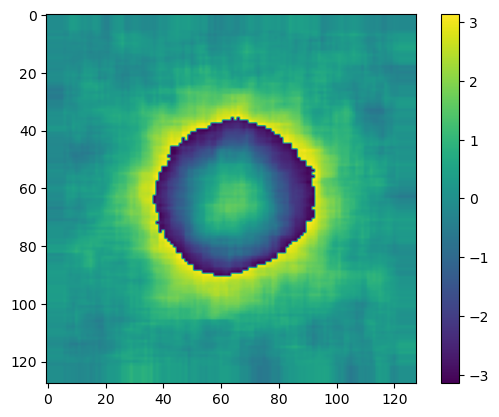

In [83]:
%%time
pl_out_evd = _core.run_phase_linking(samps3d, half_window=half_window, strides=strides, use_evd=True)

plt.figure()
plt.imshow(np.angle(pl_out_evd.cpx_phase[-1]))
plt.colorbar();

## Check the RMSE of the stacks

In [88]:
np.angle(defo_phase * pl_out_evd.cpx_phase).sum(axis=(1, 2))


array([-2.2082994e-04,  2.0244789e+03,  3.9843928e+03,  6.0656709e+03,
        7.3635610e+03,  6.0200640e+03,  5.2131104e+03,  4.9733892e+03,
        4.6177861e+03,  4.7669438e+03,  5.3150107e+03,  6.0413267e+03,
        5.9636348e+03,  5.5386807e+03,  5.3289229e+03,  5.2604209e+03,
        5.3432158e+03,  5.3595625e+03,  5.6202305e+03,  5.8893633e+03],
      dtype=float32)

In [89]:
np.angle(defo_phase * pl_out_emi.cpx_phase).sum(axis=(1, 2))


array([-7.4300624e-04,  2.0675476e+03,  4.1106870e+03,  6.2097988e+03,
        7.6416299e+03,  6.1858779e+03,  5.4277783e+03,  5.1399600e+03,
        4.8568291e+03,  4.9900049e+03,  5.5654834e+03,  6.1468540e+03,
        6.1026758e+03,  5.6602881e+03,  5.2819307e+03,  5.1390005e+03,
        5.1554697e+03,  5.2981660e+03,  5.5442490e+03,  5.9701699e+03],
      dtype=float32)

In [91]:
simulate.rmse(defo_phase, pl_out_evd.cpx_phase)

0.18451115

In [92]:
simulate.rmse(defo_phase, pl_out_emi.cpx_phase)

0.15396789